## Connecting to the robot

In [1]:
from ugot import ugot
got = ugot.UGOT()
got.initialize("192.168.88.1")
print("Connected")

192.168.88.1:50051
Connected


## Helper functions

In [ ]:
def forward(L_w, R_w):
    got.turn_motor_speed(31, R_w)
    got.turn_motor_speed(41, -L_w)

def left(L_w, R_w):
    got.turn_motor_speed(31, R_w)
    got.turn_motor_speed(41, L_w)

def right(L_w, R_w):
    got.turn_motor_speed(31, -R_w)
    got.turn_motor_speed(41, -L_w)

def stop():
    got.stop_all_servos()

In [ ]:
import time
global_speed = 30

forward(global_speed, global_speed)
time.sleep(2)
left(global_speed, global_speed)
time.sleep(2)
right(global_speed, global_speed)
time.sleep(2)
stop()

In [ ]:
num = "five"

try:
    number = int(num)
    print("That is the number", number)
except ValueError:
    print("Not a number!")

## Camera

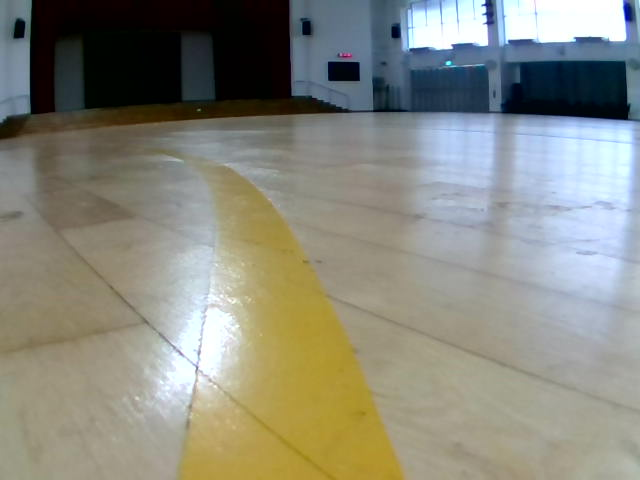

Done


NameError: name 'stop' is not defined

In [2]:
import numpy as np
import cv2
from IPython.display import display, clear_output
from PIL import Image
print("All imports resolved")

got.open_camera()

try:
    while True:
        frame = got.read_camera_data()
        if frame is not None:
            nparr = np.frombuffer(frame, np.uint8)
            img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Convert to PIL Image for display
            img_pil = Image.fromarray(img_rgb)

            # Clear previous output and display new frame
            clear_output(wait=True)
            display(img_pil)
except KeyboardInterrupt:
    print("Done")
    stop()

In [ ]:
import numpy as np
import cv2
from IPython.display import display, clear_output
from PIL import Image
print("All imports resolved")

got.open_camera()

try:
    while True:
        frame = got.read_camera_data()
        if frame is not None:
            nparr = np.frombuffer(frame, np.uint8)
            img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

            # Writing
            cv2.putText(img, text="hello", org=(50, 300), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=1, color=(0, 255, 0), thickness=2)
            
            # Drawing
            # cv2.line(image, start point, end point, color, thickness)
            cv2.line(img, (300, 100), (500, 400), (0, 255, 0), 3)

            # cv2.rectangle(image, start point, end point, color, thickness)
            cv2.rectangle(img, (50, 50), (200, 200), (0, 255, 0), 3)

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Convert to PIL Image for display
            img_pil = Image.fromarray(img_rgb)

            # Clear previous output and display new frame
            clear_output(wait=True)
            display(img_pil)
except KeyboardInterrupt:
    print("Done")
    stop()

## Line follow (no camera)

In [ ]:
got.load_models(["line_recognition"])
# 0 for single track, 1 for double track
got.set_track_recognition_line(0)

global_speed = 25

try:
    while True:
        # positive: right, negative: left, 0: middle
        offset = got.get_single_track_total_info()[0]
        rot = round(0.18 * offset)

        if offset > 10: 
            left(-global_speed, rot + global_speed)
        elif offset < 10:
            right(abs(rot) + global_speed, -global_speed)
        else:
            forward(global_speed, global_speed)

        frame = got.read_camera_data()
        if frame is not None:
            nparr = np.frombuffer(frame, np.uint8)
            img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Convert to PIL Image for display
            img_pil = Image.fromarray(img_rgb)

            # Clear previous output and display new frame
            clear_output(wait=True)
            display(img_pil)
except KeyboardInterrupt:
    print("done")
    stop()

# Maze solving

In [ ]:
import time
from IPython.display import clear_output

global_speed = 25
target_dist = 10

try:
    while True:
        R_dist = got.read_distance_data(21)
        F_dist = got.read_distance_data(22)
        L_dist = got.read_distance_data(23)

        print(f"Left: {L_dist} | Front: {F_dist} | Right: {R_dist}")
        clear_output(wait=True)

        while F_dist > 20:
            R_dist = got.read_distance_data(21)
            F_dist = got.read_distance_data(22)
            L_dist = got.read_distance_data(23)

            # Right hand rule
            if R_dist < 20:
                adj_spd = round((R_dist - target_dist) * 2)
                forward(adj_spd + global_speed, global_speed)
            else:
                forward(global_speed, global_speed)

        if R_dist < 20:
            left(global_speed, global_speed)
            time.sleep(1.1)
            stop()

        elif L_dist < 20:
            right(global_speed, global_speed)
            time.sleep(1.1)
            stop()

        else:
            right(global_speed, global_speed)
            time.sleep(2.2)
            stop()

except KeyboardInterrupt:
    stop() 

## Color rec

In [ ]:
import numpy as np
import cv2
from IPython.display import display, clear_output
from PIL import Image

# Helper function to find the biggest contour
def biggest_contour(mask, min_area=1500):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    # filter by area to reduce noise
    contours = [c for c in contours if cv2.contourArea(c) >= min_area]
    if not contours:
        return None
    return max(contours, key=cv2.contourArea)

COLOR_RANGES = {
    'red' : [(np.array([0, 120, 70]), np.array([10, 255, 255])), 
             (np.array([170, 120, 70]), np.array([179, 255, 255]))],
    'blue' : [(np.array([90, 80, 80]), np.array([130, 255, 255]))]
}

# Morphology kernel
KERNEL = np.ones((5, 5), np.uint8)

got.open_camera()

try:
    while True:
        frame = got.read_camera_data()
        if frame is not None:
            nparr = np.frombuffer(frame, np.uint8)
            img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

            # Blur to reduce noise
            blurred = cv2.GaussianBlur(img, (5, 5), 0)
            hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

            for name, ranges in COLOR_RANGES.items():
                mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
                for lo, hi in ranges:
                    mask = cv2.bitwise_or(mask, cv2.inRange(hsv, lo, hi))

                mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, KERNEL, iterations=1)
                mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, KERNEL, iterations=1)

                # Find largest blob
                cnt = biggest_contour(mask, min_area=10000)
                if cnt is not None:
                    area = cv2.contourArea(cnt)
                    x, y, w, h = cv2.boundingRect(cnt)
                    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Convert to PIL Image for display
            img_pil = Image.fromarray(img_rgb)

            # Clear previous output and display new frame
            clear_output(wait=True)
            display(img_pil)
except KeyboardInterrupt:
    print("Done")
    stop()


In [8]:
got.load_models(["line_recognition"])
got.set_track_recognition_line(0)

try:
    while True:
        info = got.get_single_track_total_info()
        offset = info[0]
        got.mecanum_move_xyz(0, 25, round(offset * 0.25))
except KeyboardInterrupt:
    got.mecanum_stop()